# Week 10

Text Processing and Analysis

## Setup

Run the following 2 cells to import all necessary libraries and helpers for this week's exercises

In [1]:
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/data_utils.py
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/text_utils.py
!wget -qO- https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/datasets/text/movie_reviews.tar.gz | tar xz

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.macl'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.macl'


### All Scikit-Learn Now!

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import string

from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, TruncatedSVD, PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from data_utils import MinMaxScaler
from data_utils import display_confusion_matrix

from text_utils import get_top_words

## Text Classification

Let's try to predict whether a given review expresses positive or negative feelings towards a movie.

We have a dataset that basically has $2$ features per record: `review` and `sentiment`.

Let's load and look:

In [3]:
reviews_df = pd.read_csv("./data/text/movie_reviews.csv")
reviews_df

,review,sentiment
0,With all this stuff going down at the moment w...,1
1,"""The Classic War of the Worlds"" by Timothy Hin...",1
2,The film starts with a manager (Nicholas Bell)...,0
3,It must be assumed that those who praised this...,0
4,Superbly trashy and wondrously unpretentious 8...,1
...,...,...
24995,It seems like more consideration has gone into...,0
24996,I don't believe they made this film. Completel...,0
24997,"Guy is a loser. Can't get girls, needs to buil...",0
24998,This 30 minute documentary Buñuel made in the ...,0


### Features

Text is a very different kind of feature...

We do want to turn it into numbers somehow in order to apply some of the methods and models we've been learning about, but how to do that exactly is not entirely obvious.

We can try to extract some numerical information about the review text. Maybe something like the length of the review or the relative amount of punctuation marks or digits can be indicative of its sentiment.

Let's define some helper functions.

In [4]:
def count_characters(st):
  return len("".join(st.split()))

def count_words(st):
  return len(st.split(" "))

def count_punctuation(st):
  return len([c for c in st if c in string.punctuation])

def count_digits(st):
  return len([c for c in st if c in string.digits])

def get_punctuation_pct(st):
  return count_punctuation(st) / count_characters(st)

def get_digit_pct(st):
  return count_digits(st) / count_characters(st)

Now, let's apply some of these to our `DataFrame` to create numerical features that we can eventually use in a classifier.

In [5]:
reviews_df["char_count"] = reviews_df["review"].apply(count_characters)
reviews_df["word_count"] = reviews_df["review"].apply(count_words)
reviews_df["punctuation_pct"] = reviews_df["review"].apply(get_punctuation_pct)
reviews_df["digit_pct"] = reviews_df["review"].apply(get_digit_pct)

reviews_df

,review,sentiment,char_count,word_count,punctuation_pct,digit_pct
0,With all this stuff going down at the moment w...,1,1830,429,0.023497,0.001093
1,"""The Classic War of the Worlds"" by Timothy Hin...",1,781,158,0.043534,0.000000
2,The film starts with a manager (Nicholas Bell)...,0,2062,377,0.031523,0.006305
3,It must be assumed that those who praised this...,0,1841,377,0.041282,0.002173
4,Superbly trashy and wondrously unpretentious 8...,1,1859,367,0.032275,0.002152
...,...,...,...,...,...,...
24995,It seems like more consideration has gone into...,0,406,87,0.044335,0.000000
24996,I don't believe they made this film. Completel...,0,802,174,0.043641,0.001247
24997,"Guy is a loser. Can't get girls, needs to buil...",0,503,126,0.057654,0.007952
24998,This 30 minute documentary Buñuel made in the ...,0,945,197,0.031746,0.008466


Before we model this data, let's look at some of these features and see if we can visually identify the negative and positive reviews on plots.

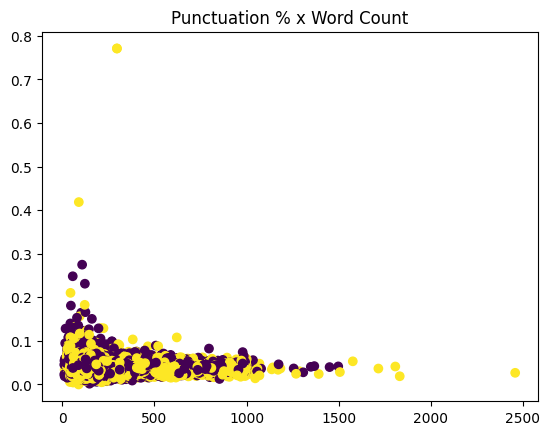

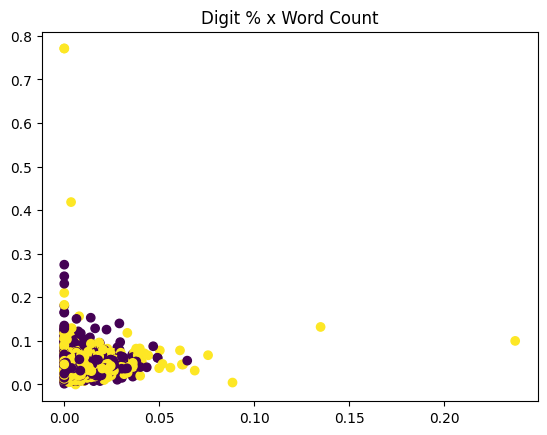

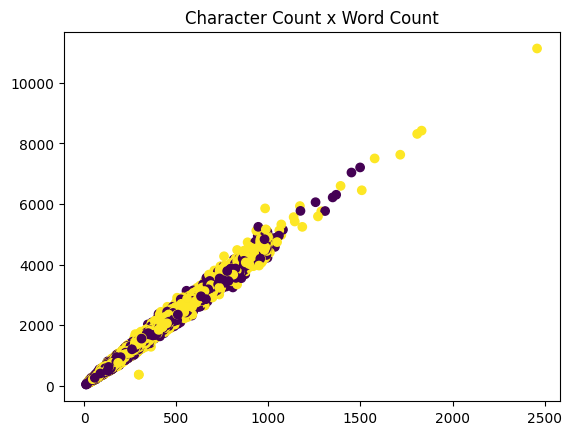

In [7]:
plt.scatter(reviews_df["word_count"], reviews_df["punctuation_pct"], c=reviews_df["sentiment"])
plt.title("Punctuation % x Word Count")
plt.show()

plt.scatter(reviews_df["digit_pct"], reviews_df["punctuation_pct"], c=reviews_df["sentiment"])
plt.title("Digit % x Word Count")
plt.show()

plt.scatter(reviews_df["word_count"], reviews_df["char_count"], c=reviews_df["sentiment"])
plt.title("Character Count x Word Count")
plt.show()

This is not very promising. It doesn't seem like these features contain enough information to help us extract meaning from the reviews.

Let's just confirm this suspicion by creating a classifier.

We'll use a `MinMaxScaler` since some of the features are already in a $[0,1]$ range.

In [6]:
mScaler = MinMaxScaler()

simple_feats_df = reviews_df.drop(columns=["review", "sentiment"])
simple_feats_scaled_df = mScaler.fit_transform(simple_feats_df)

simple_feats_scaled_df["sentiment"] = reviews_df["sentiment"]

simple_feats_scaled_df

,char_count,word_count,punctuation_pct,digit_pct,sentiment
0,0.161107,0.171090,0.030472,0.004608,1
1,0.066534,0.060433,0.056456,0.000000,1
2,0.182023,0.149857,0.040879,0.026581,0
3,0.162099,0.149857,0.053535,0.009161,0
4,0.163722,0.145774,0.041855,0.009072,1
...,...,...,...,...,...
24995,0.032726,0.031441,0.057494,0.000000,0
24996,0.068428,0.066966,0.056594,0.005257,0
24997,0.041471,0.047366,0.074767,0.033529,0
24998,0.081320,0.076358,0.041169,0.035693,0


Train/Test splitting should've been done before scaling, but this is just a quick experiment.

In [7]:
reviews_train_df, reviews_test_df = train_test_split(simple_feats_scaled_df, test_size=0.2)

reviews_train_df

,char_count,word_count,punctuation_pct,digit_pct,sentiment
12398,0.132167,0.129849,0.053282,0.027940,1
11849,0.042553,0.046958,0.030217,0.016374,0
15724,0.066354,0.061249,0.063260,0.000000,1
21841,0.079336,0.075541,0.047770,0.000000,0
2134,0.070231,0.070641,0.033130,0.000000,1
...,...,...,...,...,...
23135,0.073927,0.073499,0.037567,0.000000,1
1500,0.020555,0.021641,0.052638,0.046674,1
4979,0.060224,0.064108,0.047422,0.005930,0
7756,0.048233,0.046958,0.042629,0.029178,1


In [8]:
mClassifier = RandomForestClassifier()

train_feats = reviews_train_df.drop(columns=["sentiment"])
train_labels = reviews_train_df["sentiment"]

mClassifier.fit(train_feats, train_labels)

train_preds = mClassifier.predict(train_feats)

accuracy_score(train_labels, train_preds)

0.9985

In [9]:
test_feats = reviews_test_df.drop(columns=["sentiment"])
test_labels = reviews_test_df["sentiment"]

test_preds = mClassifier.predict(test_feats)

accuracy_score(test_labels, test_preds)

0.535

# 🤔

Our model is just as good as a random guess.

We'll have to use something else.

Back to the drawing board.

### Bag-of-Words (BoW)

This is a way of modeling sentences as a function of their words. We can think of it as a specialized version of One-Hot Encoding, where we turn our single-column `review` feature into a series of numbers that represent which words are present in that review. If a word is not present, that column gets a $0$, if the word is present, the column gets an integer that represents the total number of times that word was used in the review.

There are some specificities to keep in mind when we encode text this way. We need to figure out what constitutes a _word_ and what kind of words we want to ignore.

Do we consider the words `type`, `types`, `typed` as the same word or $3$ different words ?

Do we consider words like `a`, `the`, `of`, `in`, etc ... in our encoding ? What other kinds of words should be treated differently ?

The first consideration is part of the process of _tokenization_, or, how we turn sequences (of words) into its constitutive components (tokens). There are libraries and pre-trained models that can help us with that task.

To answer part of the second question: it's best to remove common words from text before processing it because they don't add meaning or variance to our data. These words are commonly referred to as _stop words_, or _negative dictionary_, and, again, we can find lists of common _stop words_ for different languages in text-processing libraries and packages.

<img src="./imgs/tokens-00.jpg" width="720px" />

Our dataset can have other words that show up very frequently, but aren't generally considered _stop words_. For example, a dataset about movie reviews might have the words `movie`, `good`, `director`, etc in every single review. While not typical _stop words_, they should be ignored during encoding because they add no meaningful differentiation to our data.

The same is true for words that are rare and only show up in a small fraction of our sentences/reviews.

This process of encoding text sequences by the count of their words is called Vectorization. This method of encoding keeps track of which words are present in a series of words, and how common they are, but without any significant information about the order of the words or where they occurred in the original text.

That's why models created this way are called _Bag-of-Word_ models: they model _what_ words are there, but not _where_ they occurred.

### Vectorize by Count

Let's use the `Scikit-Learn` class `CountVectorizer` to encode our reviews.

The `min_df` and `max_df` parameters to the class constructor determine the minimum and maximum document frequencies to consider when encoding our data.

With `min_df=5` and `max_df=0.75`, the vectorizer ignores words that show up in less than $5$ reviews and words that show up in more than $75\%$ of reviews.

In [10]:
reviews_df = pd.read_csv("./data/text/movie_reviews.csv")

reviews_train_df, reviews_test_df = train_test_split(reviews_df, test_size=0.2, random_state=1010)
reviews_train_df

,review,sentiment
16933,I have to admit that for the first half hour o...,1
16265,This really is the worst film I have ever seen...,0
10749,I don't know what it is with these Brady kids....,0
9197,This movie was not made by Who fans. Most of t...,0
1788,"""Fever Pitch"" is a sweet and charming addition...",1
...,...,...
4906,What a thrill ride! Twisted and thought provok...,1
6851,Why else would he do this to me? Not that I ex...,0
23029,This place in England during 1940. Three orpha...,1
8394,this was one of those $.50 cent deals of yore-...,1


In [11]:
mCV = CountVectorizer(stop_words="english", min_df=5, max_df=0.75, max_features=10_000)

reviews_train_vct = mCV.fit_transform(reviews_train_df["review"])
reviews_test_vct = mCV.transform(reviews_test_df["review"])

If we print our encoded features, we should see something like this:

<img src="./imgs/vector-00.jpg" width="720px" />

In [12]:
reviews_train_vct

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 1563221 stored elements and shape (20000, 10000)>

But we don't.

What !?

### Sparse Matrices

This is why we have to move beyond `DataFrames` for text encoding.

We have thousands of reviews and thousands of possible words in our vocabulary. Encoding this information using a `DataFrame` would be extremely inefficient and wasteful because most of the columns for any given row is most likely a $0$. Even if a review used $1\text{,}000$ unique words, that would still mean that only about $10\%%$ of our columns would have non-zero values.

### Using Sparse Matrices

The `CountVectorizer` object has functions that give us information about the words it encountered.

`get_feature_names_out()`: returns a list of the words seen in the dataset and encoded.

`inverse_transform()`: can be used to turn a sequence of word counts back into actual words, but without the order information of the original sentence.

And, we can index into our vector of reviews with `[]` to get a specific review. These are encoded as sparse matrices, so we have to do a bit of work to get to the actual words and their counts:

- It helps to use the `nonzero()` function to get a list of the indices of words that are actually present in that review.

- Once we have the indices, we can use them to access the review vector, and get the non-zero word counts from specific locations in the sparse matrix.

In [13]:
vocab = mCV.get_feature_names_out()

print(len(vocab))
display(vocab)

10000


array(['00', '000', '10', ..., 'zoom', 'zorro', 'zu'],
      shape=(10000,), dtype=object)

Get indices of non-zero counts for words in the first review:

In [14]:
reviews_train_vct[0].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([ 286, 4104, 4397, 5933,  864, 5391, 5759,  464, 4424,  974, 6704,
        3829, 7923, 9540, 5498, 9022, 9711, 9086,  552, 7227, 8720, 7221,
        3097, 5860, 7219, 2810, 7801, 3969, 3337, 3230, 4142, 3123, 4943,
        8719, 5657, 5123, 6723, 1586, 5897, 3705, 8509, 9427,  242, 3514,
        5317, 6956, 1423, 3935, 6687, 8767, 5512, 8408, 2369, 7432, 7608,
        5676, 1116, 7795, 6689, 6519, 9527, 9680, 5248, 4248, 6860, 4879,
        4726, 4738, 7209, 9283, 3755, 9718, 1569, 4467, 2197, 6380, 9606,
        5334, 8901, 8598, 4005, 8610, 1918,  938, 8348, 1846, 7621, 3411,
        2361, 1618, 3441,  921, 8568, 3062, 9309, 2455, 158

Get counts from those indices:

In [15]:
reviews_train_vct[reviews_train_vct[0].nonzero()]

matrix([[1, 1, 1, 4, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
         2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

Get words in a review:

In [16]:
mCV.inverse_transform(reviews_train_vct[0])

[array(['admit', 'half', 'hour', 'movie', 'basically', 'lost', 'mildly',
        'amusing', 'humour', 'best', 'plot', 'general', 'sense', 'verge',
        'making', 'think', 'wasting', 'time', 'apparent', 'reason',
        'suddenly', 'realized', 'enjoying', 'moment', 'realization',
        'dramatic', 'scene', 'grabbed', 'fact', 'exciting', 'happens',
        'entire', 'just', 'sudden', 'meant', 'largely', 'pointless',
        'charm', 'morgan', 'freeman', 'starred', 'unnamed', 'actor',
        'finds', 'little', 'project', 'career', 'going', 'play',
        'supermarket', 'manager', 'spends', 'day', 'research', 'role',
        'meets', 'bonds', 'scarlet', 'played', 'paz', 'vega', 'wants',
        'life', 'helps', 'prepare', 'job', 'interview', 'introduces',
        'real', 'truly', 'funny', 'watching', 'character', 'identified',
        'credits', 'overwhelmed', 'visit', 'local', 'target', 'store',
        'great', 'strange', 'completely', 'believable', 'sort', 'combined',
        'r

Or, using the non-zero indices to index into the `vocab` list:

In [17]:
vocab[reviews_train_vct[0].nonzero()[1]]

array(['admit', 'half', 'hour', 'movie', 'basically', 'lost', 'mildly',
       'amusing', 'humour', 'best', 'plot', 'general', 'sense', 'verge',
       'making', 'think', 'wasting', 'time', 'apparent', 'reason',
       'suddenly', 'realized', 'enjoying', 'moment', 'realization',
       'dramatic', 'scene', 'grabbed', 'fact', 'exciting', 'happens',
       'entire', 'just', 'sudden', 'meant', 'largely', 'pointless',
       'charm', 'morgan', 'freeman', 'starred', 'unnamed', 'actor',
       'finds', 'little', 'project', 'career', 'going', 'play',
       'supermarket', 'manager', 'spends', 'day', 'research', 'role',
       'meets', 'bonds', 'scarlet', 'played', 'paz', 'vega', 'wants',
       'life', 'helps', 'prepare', 'job', 'interview', 'introduces',
       'real', 'truly', 'funny', 'watching', 'character', 'identified',
       'credits', 'overwhelmed', 'visit', 'local', 'target', 'store',
       'great', 'strange', 'completely', 'believable', 'sort', 'combined',
       'romantic', 'fath

We can use these functions to order the words of a review by frequency.

The process is:

- Get a `review` by indexing into our list of encoded reviews
- Count the number of tokens/words in the review
- Use [argsort()](https://numpy.org/doc/2.1/reference/generated/numpy.argsort.html) to get the order of indices that would sort the word counts
  - Use negative counts to get the counts ordered from largest to smallest
- Use the first `word_count` items of this array to index into our vocab and get the actual words of the review

In [18]:
review = reviews_train_vct[0]

word_count = len(review.nonzero()[0])

sorted_idxs = (-review.toarray()[0]).argsort()

vocab[sorted_idxs[:word_count]]

array(['movie', 'vega', 'supermarket', 'suddenly', 'role', 'life', 'lost',
       'realized', 'freeman', 'turns', 'truly', 'unnamed', 'target',
       'verge', 'visit', 'time', 'strange', 'sudden', 'store', 'stick',
       'sort', 'sense', 'starred', 'spends', 'scene', 'scarlet',
       'research', 'romantic', 'realization', 'think', 'wants',
       'watching', 'project', 'real', 'reason', 'plot', 'played', 'play',
       'paz', 'prepare', 'overwhelmed', 'morgan', 'mildly', 'moment',
       'meets', 'meant', 'manager', 'pointless', 'making', 'local',
       'little', 'largely', 'just', 'job', 'introduces', 'interview',
       'identified', 'humour', 'hour', 'helps', 'happens', 'half',
       'great', 'wasting', 'grabbed', 'going', 'general', 'funny',
       'finds', 'feel', 'father', 'fact', 'exciting', 'entire',
       'enjoying', 'end', 'dramatic', 'delightfully', 'day', 'daughter',
       'credits', 'completely', 'combined', 'chemistry', 'charm',
       'charming', 'character', 'car

This seems like a useful enough operation, that maybe it should be a function that we can use on any sparse matrix of frequency counts...

The `get_top_words(cnt, vocab, n)` function in `text_utils` will return the top `n` words of `cnt`, a count vector or count matrix (list of vectors).

Omitting `n` makes the function return all of the words present in the sequences, ordered by frequency.

The returned value is a tuple of words and their counts.

In [19]:
from text_utils import get_top_words

get_top_words(reviews_train_vct[:2], vocab)

([array(['movie', 'vega', 'supermarket', 'suddenly', 'role', 'life', 'lost',
         'realized', 'freeman', 'turns', 'truly', 'unnamed', 'target',
         'verge', 'visit', 'time', 'strange', 'sudden', 'store', 'stick',
         'sort', 'sense', 'starred', 'spends', 'scene', 'scarlet',
         'research', 'romantic', 'realization', 'think', 'wants',
         'watching', 'project', 'real', 'reason', 'plot', 'played', 'play',
         'paz', 'prepare', 'overwhelmed', 'morgan', 'mildly', 'moment',
         'meets', 'meant', 'manager', 'pointless', 'making', 'local',
         'little', 'largely', 'just', 'job', 'introduces', 'interview',
         'identified', 'humour', 'hour', 'helps', 'happens', 'half',
         'great', 'wasting', 'grabbed', 'going', 'general', 'funny',
         'finds', 'feel', 'father', 'fact', 'exciting', 'entire',
         'enjoying', 'end', 'dramatic', 'delightfully', 'day', 'daughter',
         'credits', 'completely', 'combined', 'chemistry', 'charm',
        

### Classifying by Count

Ok. After that little bit of a detour to explore vector count sparse matrices, we are back to our classification problem.

Seems like we should be able to classify whether a review is positive or negative by looking at the words used...

Let's train a `RandomForestClassifier` and validate with our test dataset.

In [20]:
mClassifier = RandomForestClassifier()

train_labels = reviews_train_df["sentiment"]

mClassifier.fit(reviews_train_vct, train_labels)

train_preds = mClassifier.predict(reviews_train_vct)

accuracy_score(train_labels, train_preds)

1.0

Not bad. Promising.

In [21]:
test_labels = reviews_test_df["sentiment"]

test_preds = mClassifier.predict(reviews_test_vct)

accuracy_score(test_labels, test_preds)

0.8458

Ok! This is not bad.

After learning about count vectorization and sparse matrices, the code for doing this is actually quite simple.

We could adjust parameters of the classifier or the vectorizer to improve this, but using a `RandomForestClassifier` for this task is quite inefficient.

Let's look at a different kind of classifier before we continue exploring vectorization.

### Naive Bayes

Bayesian statistics is a complete and complex field of math and philosophy. At a high level, it's a theory that allows for probabilities (of events, measurements, classifications, etc) to be updated based on the presence of (new) data.

We are going to look at a very slim portion of Bayesian statistics to get a basic understanding of how this theory can be applied within Machine Learning algorithms.

The Naive Bayes methods are a set of supervised learning algorithms based on a version of Bayes' theorem that assumes that all of our features are independent.

As applied to a classification problem, this theorem has the following form:

$$P\left(y \middle| x_1, x_2, \ldots, x_n\right) = \frac{P\left(y\right)P\left(x_1, x_2, \ldots, x_n \middle| y \right)}{P\left(x_1, x_2, \ldots, x_n\right)}$$

This is an eyeful, but given that $y$ is the class associated with feature measurements $x_1, x_2, \ldots, x_n$, it reads:

The probability that a given set of measurements ($x_1, x_2, \ldots, x_n$) represents an object of class $y$ is equal to the probability of seeing an object of class $y$ in our dataset, multiplied by the probability that an object of class $y$ has measurements $x_1, x_2, \ldots, x_n$, divided by how common that particular set of measurements are.

$P\left(y\right)$ is calculated by measuring how many items of our dataset represent an object of class $y$. If we have $10$ objects that are $y$ in a dataset of $50$ objects, our $P\left(y\right) = \frac{10}{50}$.

Likewise, $P\left(x_1, x_2, \ldots, x_n\right)$ represents how many times this exact combination of measurements showed up in our dataset. If only one row out of $50$ has this combination of input features, then $P\left(x_1, x_2, \ldots, x_n\right) = \frac{1}{50}$.

$P\left(x_1, x_2, \ldots, x_n \middle| y \right)$ is the trickier bit, but it gets simplified by the _naive_ assumption of feature independence and can be split into multiple terms:

$P\left(x_1 \middle| y \right) \cdot P\left(x_2 \middle| y \right) \cdot\ldots\cdot P\left(x_n \middle| y \right)$

These are the probabilities that items of class $y$ have specific values for $x_1, x_2, \ldots x_n$. For example, if in our dataset of $50$ elements, $10$ have class $y$, and $2$ out of those $10$ have a particular value $x_1$ for the first feature, $P\left(x_1 \middle| y \right) = \frac{2}{10}$.

#### Naive Bayes Text Example

Let's pretend we want to calculate the probability that a review with the words `awful`, `bloody`, `guns` and `park` is **negative**.

This is equivalent to calculating:
$$P\left(negative \middle| \text{awful}, \text{bloody}, \text{guns}, \text{park} \right) = \frac{P\left(negative\right) P\left(\text{awful}, \text{bloody}, \text{guns}, \text{park} \middle| negative \right)}{P\left(\text{awful}, \text{bloody}, \text{guns}, \text{park}\right)}$$

$P\left(\text{negative}\right)$ is equal to the proportion of **negative** reviews in the dataset. If half are positive and half are negative, $P\left(\text{negative}\right) = 0.5$.

$P\left(\text{awful}, \text{bloody}, \text{guns}, \text{park}\right)$ is the proportion of the number of reviews in the dataset that have all four words `awful`, `bloody`, `guns` and `park`.

$P\left(\text{awful}, \text{bloody}, \text{guns}, \text{park} \middle| negative \right)$ can be simplified to $P\left(\text{awful} \middle| negative \right) \cdot P\left(\text{bloody} \middle| negative \right) \cdot P\left(\text{guns} \middle| negative \right) \cdot P\left(\text{park} \middle| negative \right)$

$P\left(\text{awful} \middle| negative \right)$ is the proportion of negative reviews that have the word `awful`, $P\left(\text{bloody} \middle| negative \right)$ is the proportion of negative review with `bloody` in it, etc etc etc.

### Why ????

It might not be obvious at first, but when used for classification of datasets with sparse feature vectors, the process described above can be extremely efficient because _fitting_ the model means calculating a few probability constants from our training dataset. All of the $P()$ terms on the right hand side of the Bayes equation are basic proportions calculated with addition and division operations.

`Scikit-Learn` has different flavors of Naive Bayes classifiers that make further assumptions about the distributions of the input features and how $P\left(X \middle| y \right)$ can be simplified.

- [Gaussian](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) Naive Bayes assumes the features have gaussian distributions. This is good for datasets with continuous-valued inputs.
- [Bernoulli](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) Naive Bayes assumes the features are all binary values (One-Hot Encoding).
- [Categorical](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html) Naive Bayes assumes our features are integers that represent categories (Ordinal Encoding).
- [Multinomial](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) Naive Bayes assumes our features are discrete measurements.

Given that the feature vectors computed with `CountVectorizer` represent word counts, it makes sense for us to use a Multinomial classifier for this task.

In [22]:
# TODO: repeat classification using the appropriate Bayes model
mClassifier = MultinomialNB()
mClassifier.fit(reviews_train_vct, train_labels)

#train data
train_preds = mClassifier.predict(reviews_train_vct)
accuracy_score(train_labels, train_preds)

0.874

In [23]:
# test data
test_preds = mClassifier.predict(reviews_test_vct)
accuracy_score(test_labels, test_preds)

0.8486

### N-Grams

Now that we have an efficient classifier for sparse count feature vectors we can finally experiment with n-grams.

In its simplest form, the Bag-of-Words method doesn't take into consideration any information about the order or location of the words in a sequence of words. We can, however, set it up to count pairs (or triplets, or quadruplets, etc) of words instead of single words.

So, instead of breaking up "_it was a good movie_", like this:
|it|was|a|good|movie|
|-|-|-|-|-|

It breaks it up like this:

|it was|was a|a good|good movie|
|-|-|-|-|

These are the 2-grams (or bi-grams) of our sentence, but the concept can be extended to any integer value of $n$ to extract counts for different lengths of n-grams.

While this doesn't help with location information, it does extract some information about word order and common phrases.

To extract n-grams during vectorization, we can give `CountVectorizer` a range of values to consider with the parameter `ngram_range`. A value of $(2,2)$ will only extract bigrams, while $(1,2)$ will extract counts for single words and pairs of words.

In [24]:
mCV = CountVectorizer(stop_words="english", min_df=5, max_df=0.75, max_features=50_000, ngram_range=(2, 2))

reviews_train_vct = mCV.fit_transform(reviews_train_df["review"])
reviews_test_vct = mCV.transform(reviews_test_df["review"])

The `CountVectorizer` functions we saw above and our `get_top_words()` function will work the same way. The only difference is that right now our features represent counts for pairs of words.

In [25]:
vocab = mCV.get_feature_names_out()
print(len(vocab))
vocab

39056


array(['000 00', '000 000', '000 budget', ..., 'zone episode',
       'zorro fighting', 'zu warriors'], shape=(39056,), dtype=object)

In [26]:
mCV.inverse_transform(reviews_train_vct[0])

[array(['half hour', 'hour movie', 'movie basically', 'mildly amusing',
        'plot general', 'making think', 'wasting time', 'apparent reason',
        'dramatic scene', 'exciting happens', 'entire movie', 'movie just',
        'realized movie', 'movie meant', 'morgan freeman', 'career going',
        'paz vega', 'job interview', 'real life', 'truly funny',
        'funny watching', 'completely believable', 'father daughter',
        'feel lost', 'end turns', 'charming movie', 'movie 10'],
       dtype='<U29')]

In [27]:
get_top_words(reviews_train_vct[0], vocab)

(['wasting time',
  'truly funny',
  'realized movie',
  'real life',
  'plot general',
  'paz vega',
  'movie meant',
  'movie just',
  'movie basically',
  'movie 10',
  'morgan freeman',
  'mildly amusing',
  'making think',
  'job interview',
  'hour movie',
  'half hour',
  'funny watching',
  'feel lost',
  'father daughter',
  'exciting happens',
  'entire movie',
  'end turns',
  'dramatic scene',
  'completely believable',
  'charming movie',
  'career going',
  'apparent reason'],
 [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1])

### Train and Validate

Let's try it out !

In [28]:
mClassifier = MultinomialNB()

train_labels = reviews_train_df["sentiment"]

mClassifier.fit(reviews_train_vct, train_labels)

train_preds = mClassifier.predict(reviews_train_vct)

accuracy_score(train_labels, train_preds)

0.93795

In [29]:
test_labels = reviews_test_df["sentiment"]

test_preds = mClassifier.predict(reviews_test_vct)

accuracy_score(test_labels, test_preds)

0.8438

### TF-IDF

Another way to vectorize our reviews into a Bag-of-Words is to use a slightly smarter and more specific way of counting words in our reviews.

Term Frequency-Inverse Document Frequency is a technique used to "count" words and scale the counts by how important a word might be to a document/review.

It does this by calculating two values for each tokenized word in a review:
- _**Term Frequency**_: the relative frequency of the word within a document/review.
- _**Document Frequency**_: the relative frequency of the number of documents in the dataset that have this word. It measures how much information a word carries by calculating how rare it is. What gets used in the actual `tf-idf` calculation is the $log()$ of the inverse of this value.

In math, this is:

$$ tf(t, d) = \frac{Count(t)}{| d |} \hspace{20pt}\hspace{20pt} idf(t, D) = log\left(\frac{| D |}{Count(d : t \in d)}\right)$$

Where:
- $Count(t)$ is the number of times a word appears in a document.
- $| d |$ is the length of the document, in words.
- $| D |$ is the total number of documents in the dataset.
- $Count(d : t \in d)$ is the number of documents in the dataset that have the word $t$ in them.

Of course `cikit-Learn` has a builtin tf-idf Vectorizer that will do this for us. We instantiate it just like the `CountVectorizer`:

In [31]:
mTfidV = TfidfVectorizer(stop_words="english", min_df=5, max_df=0.75, max_features=50_000, ngram_range=(1, 1))

reviews_train_vct = mTfidV.fit_transform(reviews_train_df["review"])
reviews_test_vct = mTfidV.transform(reviews_test_df["review"])

The `TfidfVectorizer` has all the functions we saw above in the `CountVectorizer` object, and our `get_top_words()` function will work the same way with our tf-idf vectors. The difference is that now our features are not plain integer counts of words or n-grams, but our tf-idf importance metric. The higher the metric, the more significant the word (or n-gram) within our vocabulary.

In [96]:
vocab = mTfidV.get_feature_names_out()
print(len(vocab))
vocab

50000


array(['00', '000', '000 00', ..., 'zucker', 'zulu', 'zuniga'],
      shape=(50000,), dtype=object)

In [97]:
mTfidV.inverse_transform(reviews_train_vct[0])

[array(['admit', 'half', 'hour', 'movie', 'basically', 'lost', 'mildly',
        'amusing', 'humour', 'best', 'plot', 'general', 'sense',
        'pointlessness', 'verge', 'making', 'think', 'wasting', 'time',
        'apparent', 'reason', 'suddenly', 'realized', 'enjoying',
        'blinding', 'moment', 'realization', 'dramatic', 'scene',
        'grabbed', 'fact', 'exciting', 'happens', 'entire', 'just',
        'sudden', 'meant', 'largely', 'pointless', 'charm', 'morgan',
        'freeman', 'starred', 'unnamed', 'actor', 'finds', 'little',
        'project', 'career', 'going', 'play', 'supermarket', 'manager',
        'spends', 'day', 'neighbourhood', 'research', 'role', 'meets',
        'bonds', 'scarlet', 'played', 'paz', 'vega', 'cashier', 'wants',
        'life', 'helps', 'prepare', 'job', 'interview', 'auditioning',
        'introduces', 'real', 'truly', 'funny', 'watching', 'character',
        'identified', 'credits', 'overwhelmed', 'visit', 'local', 'target',
        'store'

In [98]:
get_top_words(reviews_train_vct[0], vocab, 10)

(['pointlessness',
  'vega',
  'supermarket',
  'freeman',
  'realized',
  'suddenly',
  'exciting happens',
  'blinding',
  'end turns',
  'neighbourhood'],
 [0.23070862531566066,
  0.21492302505356076,
  0.20850963342394152,
  0.18149196804575618,
  0.14913131141939445,
  0.13535732273706216,
  0.12207072784439377,
  0.12207072784439377,
  0.12207072784439377,
  0.12044134157359115])

### Classification with tf-idf

This stays the same.

While the multinomial classifier normally requires integer features, in practice, fractional counts such as the ones computed with a `TfidfVectorizer` also work.

We could turn these into `int`s by multiplying them by $100$... but we don't have to. A `MultinomialNB` is still the best option because our td-idf values represent a kind of count. They aren't continuous, unbounded, `float` values, so it wouldn't make sense to use a Gaussian Bayes classifier, for example.

In [99]:
mClassifier = MultinomialNB()

train_labels = reviews_train_df["sentiment"]

mClassifier.fit(reviews_train_vct, train_labels)

train_preds = mClassifier.predict(reviews_train_vct)

accuracy_score(train_labels, train_preds)

0.9239

In [100]:
test_labels = reviews_test_df["sentiment"]

test_preds = mClassifier.predict(reviews_test_vct)

accuracy_score(test_labels, test_preds)

0.874

Not bad.

How does the choice of n-gram range affect classification by tf-idf ?

In [ ]:
# TODO: Evaluate the effect of n-grams in the TfidfVectorizer

# > ngram range, > loading time, > accuracy

## Unsupervised Learning

Our movie reviews dataset is rich in information. It contains details and descriptions of movies, actors, directors, etc, along with other patterns and trends that weren't directly used while training our binary sentiment classifier. This is probably true of most natural language text datasets, and probably has to due with the nature of languages and how they evolved to have structure and carry dense amounts of information... Unlike a pixel, a single word by itself will mean something, even if ambiguously.

What this means is, there are usually other patterns and trends, that are independent of outcome variables, that we can try to extract from datasets like this.

How do we extract information when we don't have "answers" in our dataset ? Unsupervised Learning! And in this case we'll start by looking at Clustering.

### Clustering

Just like we clustered numerical data and pixels by finding locations in our feature space to represent, or capture, sections of our dataset, we can imagine finding specific locations in our feature space to represent sub-sets of our reviews.

When we clustered pixels, our original features were `R`, `G`, `B` channel values, and so our cluster centers could be considered a set of representative colors for our image.

When we clustered wines, the cluster centers had the same $10$ features as our original dataset, and represented meaningful characteristics for the wines in each clusters.

For reviews ... our dataset has $10\text{,}000$ to $50\text{,}000$ features after we vectorize our reviews. Even if most of these values are $0$, we still have a dataset with $50\text{,}000$ features. If we cluster based on these features, the resulting cluster centers will have the same features and values with the same meaning as the original data.

This means that instead of being representative colors or wine characteristics, our cluster centers will be sets of words that represent a subsection of out dataset.

Let's take a look. We'll start by clustering our reviews into $8$ groups:

In [32]:
reviews_df = pd.read_csv("./data/text/movie_reviews.csv")

In [ ]:
mVec = TfidfVectorizer(stop_words="english", min_df=5, max_df=0.5, max_features=50_000, ngram_range=(2, 3))

reviews_vct = mVec.fit_transform(reviews_df["review"])

In [67]:
vocab = mVec.get_feature_names_out()
print(len(vocab))

50000


In [68]:
mClust = KMeans(n_clusters=8, random_state=800)
reviews_km = mClust.fit_predict(reviews_vct)

We can check our cluster centers:

In [69]:
mClust.cluster_centers_

array([[0.        , 0.        , 0.00039602, ..., 0.00019561, 0.00019561,
        0.00040856],
       [0.00064305, 0.00043253, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.00025883, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00012353, 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(8, 50000))

# 🤔
Maybe we can check the shape of these... 

In [70]:
mClust.cluster_centers_.shape

(8, 50000)

Ok. That makes sense. We have $8$ clusters with about $24\text{,}000$ features each.

We can think of these as the list of words that would've been in the $8$ most representative reviews of our dataset.

We can "unpack" them using our `get_top_words()` function. The cluster centers are the reviews, the `TfidfVectorizer` object has our vocabulary and we can look at the top $8$ - $10$ words in each review:

In [71]:
get_top_words(mClust.cluster_centers_, vocab, 8)[0]

[['don know',
  've seen',
  'movie don',
  'movie don know',
  'don think',
  'just don',
  'really don',
  'really don know'],
 ['low budget',
  'low budget movie',
  'budget film',
  'budget movie',
  'low budget film',
  'budget horror',
  'low budget horror',
  'special effects'],
 ['don waste',
  'don waste time',
  'waste time',
  'waste time money',
  'time money',
  'waste time watching',
  'time watching',
  'don waste money'],
 ['special effects',
  'looks like',
  'look like',
  'sci fi',
  've seen',
  'science fiction',
  'really bad',
  'bad acting'],
 ['ve seen',
  'year old',
  'new york',
  'years ago',
  'real life',
  'movie just',
  'don think',
  'watch movie'],
 ['main characters',
  'movie watch',
  'watch movie',
  've seen',
  'great movie',
  'good movie',
  'great movie watch',
  'really good'],
 ['watching movie',
  'worth watching',
  'end movie',
  'movie worth watching',
  'movie worth',
  'film worth watching',
  'movie movie',
  'film worth'],
 ['good 

### Interpretation

There's something here.

Some of the cluster center words seem to be indicative of the type of movies in those cluster, or even whether they are TV series.

Can we improve the legibility of our clusters ?

In [39]:
# TODO: Experiment with CountVectorizer, the TfidfVectorizer parameters and/or N-grams


# ngram 1,1 - (8, 26964)
# ngram 1,3 - (8, 50000)
# ngram 2,3 - (8, 50000)

26964


(8, 26964)

### Decomposition

We're clustering over $20\text{,}000$ - $50\text{,}000$ features of very sparse data. KMeans clustering and other algorithms might benefit from a reduction in the number of features that they have to consider.

Last week we saw how to do something like this with `PCA`. `PCA` is the MVP of all decomposition algorithms, and we could use `PCA` here, but given our type of data, we should use something a little more specific.

If we read the documentation for `PCA` it will mention something about how it _centers the data_ before calculating the decomposition, meaning that it shifts all of the input features so their average is $0$. This is fine for continuous features, and in most of those cases our data will already have been shifted and normalized using something like `StandardScaler` by the time it gets to `PCA`.

But, it doesn't make sense to do that with our text features here due to the scale and sparseness of our data. First, it is very inefficient to go through the process of calculating averages and shifting these features. Second, even if we are using tf-idf values that aren't whole numbers, they don't really represent continuous values of a distribution; they're more like counters that use floating point values, so calculating these averages can introduce unwanted distortions to our data.

### Singular Value Decomposition

We can use a more general form of the `PCA` algorithm called _Singular Value Decomposition_ that, like `PCA`, will decompose our dataset into smaller datasets of combined features ordered by importance, but unlike `PCA` it doesn't have to center our data before processing.

The computation for doing `SVD` and `PCA` decomposition is the same, but due to the centering of the data, `PCA` can take some shortcuts.

If we can think of `PCA` decomposition as something that refactors our dataset into two dense matrices like this, where the first one holds our new features and can be _abbreviated_ by selecting columns with the greatest amount of combined variance:

<img src="./imgs/pca-01.jpg" width="720px" />

Singular Value Decomposition does something like this:

<img src="./imgs/svd-01.jpg" width="720px" />

It refactors our data into $3$ matrices, where one of them only has elements on the diagonal. We get our transformed dataset by multiplying the first matrix by a _truncated_/_abbreviated_ version of this diagonal matrix.

Same... but different.

The details of the math aren't very crucial, since `Scikit-Learn` will handle all of the computations for us, we just have to remember that when decomposing sparse feature vectors or features that represent counts, it is better to use `SVD` instead of `PCA`.

### Latent Semantic Analysis

Using `TruncatedSVD` on a feature vector of tf-idf values is so common that it has its own name, _Latent Semantic Analysis_, and like `PCA` or clustering, we can use it to uncover some hidden patterns in our data.

We'll use it in a slightly different manner than how we used `PCA` to reduce our data before modeling.

Like `PCA`, the components of our `TruncatedSVD` decomposition represent new axes for our transformed data, and are linear combinations of the original features in our dataset.

Unlike the data we looked at with `PCA`, our feature space here has so many dimensions, that just looking at the top features that contribute to each of our components can give us an idea of the topics in our dataset.

This isn't always possible with non-sparse datasets because when every row of a dataset has a value for every feature, and we have few features, a lot of the `PCA` components might end up having the same contributing features, but with different weights.

For example, if we consider the diamond dataset, maybe the components from our `PCA` are all mostly made up of different combinations of `length`, `width` and `height`.

With a dataset of sparse word count features, maybe our first component is mostly made up of a combination of the words `car` and `bottle`, the second component is mostly a combination of the words `flower` and `water`, etc...

#### Reload Dataset

Let's start afresh: let's reload our dataset and run `tf-idf` vectorization.

Like with clustering, we won't worry about separating our dataset into train/test subsets since this is mostly exploratory data analysis and we're not so much interested in the predictive capabilities of our models right now.

In [47]:
reviews_df = pd.read_csv("./data/text/movie_reviews.csv")

In [48]:
mVec = TfidfVectorizer(stop_words="english", min_df=5, max_df=0.9, max_features=50_000, ngram_range=(1, 2))

reviews_vct = mVec.fit_transform(reviews_df["review"])

In [49]:
vocab = mVec.get_feature_names_out()
print(len(vocab))

50000


#### Decompose

We'll decompose our dataset into $10$ components.

This means that we'll transform our original $25\text{,}000 \times 50\text{,}000$ sparse tf-idf document matrix into a dense $25\text{,}000 \times 10$.

In [50]:
svd = TruncatedSVD(n_components=10, random_state=1010)
reviews_svd = svd.fit_transform(reviews_vct)

These are the first few rows of our transformed dataset. Like with `PCA`, the original meaning of our columns is gone and each of these $10$ columns is a linear combination of the original $50\text{,}000$ features.

In [51]:
reviews_svd[:5]

array([[ 0.14799118,  0.0130868 ,  0.02139894, -0.04085307,  0.00829327,
        -0.06758722,  0.018244  , -0.0096642 ,  0.00286645,  0.00422302],
       [ 0.10883462, -0.01894415, -0.0158388 ,  0.0495169 ,  0.02284049,
         0.00502068, -0.04114517, -0.02569973, -0.00408058, -0.00057093],
       [ 0.10560815, -0.0441824 , -0.0177544 , -0.0138997 , -0.06387948,
         0.03662942, -0.03435587, -0.00103323,  0.02271885, -0.01542301],
       [ 0.11628391, -0.04564684,  0.02027474,  0.01818848,  0.01917333,
        -0.01818767, -0.0025584 , -0.00594817, -0.00447358,  0.011977  ],
       [ 0.1225766 , -0.02709449, -0.02635288, -0.01862161, -0.04801883,
        -0.02032132, -0.01130515,  0.0129694 , -0.00535179, -0.0231041 ]])

### Topic Extraction

Unlike `PCA`, the $\text{top-}8$ features in each of these components should give us an idea of the kinds of documents/records we have in our dataset.

In [52]:
get_top_words(svd.components_, vocab, 7)[0]

[['movie', 'film', 'like', 'just', 'good', 'really', 'story'],
 ['movie', 'movies', 'bad', 'watch', 'don', 'worst', 'watch movie'],
 ['film', 'bad', 'worst', 'horror', 'acting', 'films', 'waste'],
 ['movie', 'film', 'great', 'story', 'book', 'love', 'excellent'],
 ['series', 'great', 'film', 'think', 'watch', 'seen', 've'],
 ['good', 'series', 'great', 'action', 'acting', 'best', 'cast'],
 ['good', 'funny', 'really', 'comedy', 'great', 'just', 'love'],
 ['seen', 've', 've seen', 'funny', 'worst', 'comedy', 'best'],
 ['horror', 'films', 'gore', 'like', 'budget', 'really', 'horror movie'],
 ['story', 've', 've seen', 'seen', 'characters', 'character', 'book']]

### Interpretation

Just like with clustering above, further refinement of the dataset would be needed in order to get very separated and unique topics, but the lists above do show trends in the content of the reviews. We can see certain movie genres and even some indication of the sentiment of the reviews.

A possible next step would further filter out the list of allowed words in our initial tokenization and remove certain common words like `movie`, `movies`, `film`, `good`, `bad`, `like`, etc.

## Classification for other dataset.

Now that we know all of the tricks of working with text data, let's look at more significant text classification problems.

The datasets [HERE](https://github.com/PSAM-5020-2025S-A/5020-utils/tree/refs/heads/main/datasets/text/amazon_reviews) have review information for different categories of amazon products.

Books is the largest of the datasets, so we can start with that one.

The dataset not only has the text of each review, and some irrelevant information about the reviewer, but also includes a numerical rating of the product. These ratings are whole numbers between $1$ and $5$, which means we're looking at a multi-class classification problem.

### Let's Load

Let's download, load and take a look at our data.

In [72]:
!wget -qO- https://github.com/PSAM-5020-2025S-A/5020-utils/raw/refs/heads/main/datasets/text/amazon_reviews/books.tar.gz | tar xz

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.macl'


In [73]:
reviews_full_df = pd.read_csv("./data/text/amazon_reviews/books.csv")
reviews_full_df

,asin,date,product_name,rating,review_text,reviewer,title
0,1884956068,"April 6, 2000",Manual pediï¿½trico para los dueï¿½os del nuev...,5.0,This all-Spanish handbook for parents with new...,Midwest Book Review,A mainstay reference for Spanish-speaking home...
1,0679728740,"October 20, 2006",Child of God: Books: Cormac Mccarthy,5.0,McCarthy's writing and portrayal of Lester Bal...,Brian Asquith,You want the necrophiliac to escape?
2,0679728740,"September 26, 2006",Child of God: Books: Cormac Mccarthy,2.0,Do you giggle uncontrollably when poking corps...,Bruce Miller,Low brow and juvenile
3,0679728740,"July 24, 2005",Child of God: Books: Cormac Mccarthy,5.0,I was initiated into the world of Cormac McCar...,"Christopher Davis ""Christopher E.D.""","McCarthy, a brave writer with an incredible co..."
4,0679728740,"November 20, 2002",Child of God: Books: Cormac Mccarthy,4.0,I cannot speak to the literary points in the n...,Alex Johnson,SEVIERVILLE in Child of God
...,...,...,...,...,...,...,...
219995,0374158940,"November 6, 2006",From Beirut to Jerusalem: Books: Thomas L Frie...,4.0,Consent & deny. Filling in the gaps with retro...,tom c,Tommy 2-pews
219996,0374158940,"November 5, 2006",From Beirut to Jerusalem: Books: Thomas L Frie...,4.0,"Having spent the last year in the Near East, I...",Aaron Mang,From Beirut to Jerusalem
219997,0374158940,"November 3, 2006",From Beirut to Jerusalem: Books: Thomas L Frie...,5.0,This story tells a well articulated synopsis a...,"Michael Rehmeyer ""exmeromotu""",Lebanon Synopsis
219998,0374158940,"October 31, 2006",From Beirut to Jerusalem: Books: Thomas L Frie...,5.0,For century's it has been back and forth and b...,"D. L. George ""Red Wine Quaffer""",will we never grow up?


This is a pretty big dataset with $220\text{,}000$ rows of book reviews.

Let's take a closer look at our output label, the `rating` column, to see how its values are distributed.

In [74]:
reviews_full_df["rating"].value_counts()

rating
5.0    138154
4.0     50689
1.0     17014
2.0     14143
Name: count, dtype: int64

# 🫤

That's pretty uneven. A model could just guess $5$ all the time and be correct $60\%$ of the time.

When training a classifier we want to keep the values of our output label balanced in order to avoid any kind of artificial biasing of the model during training.

Let's re-balance the dataset. We'll do this by storing the number of reviews that have the least common rating and then getting an equal number of random ratings for each of the other possible rating values.

We have the ability of grouping our `DataFrame` rows by one of the columns and then sampling an equal number of reviews from each of these groups. The code for doing this is concise, but not very intuitive, requiring some extraneous parameters and function calls:

In [75]:
min_count = reviews_full_df["rating"].value_counts().min()

def sample_min(df):
  return df.sample(min_count, random_state=10010)

rg = reviews_full_df.groupby("rating")
reviews_balanced_df = rg[reviews_full_df.columns].apply(sample_min).reset_index(drop=True)

reviews_balanced_df

,asin,date,product_name,rating,review_text,reviewer,title
0,088266266X,"August 27, 2004",Be Your Own House Contractor: Save 25% Without...,1.0,I read the book since I am building a house so...,"Bonie K. Kane ""K Kane""","Boring reading with no information, WASTE OF TIME"
1,0385420161,"October 29, 2006",Like Water for Chocolate: Books: Laura Esquivel,1.0,This book was recommended to me by so many peo...,"C. L. F. Kuehn ""Lit Girl""",like wasting my time for nothing
2,0787982571,"September 21, 2005","The Reading Teacher's Book Of Lists, 5th Editi...",1.0,"THe Book is great, but the seller took forever...","Stefanie Sorensen ""soren""",Reading Teachers Book od List
3,047146502X,"May 31, 2006",The Case for Israel: Books: Alan Dershowitz,1.0,The concept that Israel needs a defence for it...,"Gil Rosenberg ""Truth in print""","NO NEED FOR ""A CASE FOR ISRAEL"" AT ALL"
4,055357292X,"October 13, 2003",Heavy Weather: Books: Bruce Sterling,1.0,"Like others, I bought this book because of rec...","Julie Fugett ""Geek Girl""",Has Bruce Sterling actually TALKED to any comp...
...,...,...,...,...,...,...,...
56567,0375726403,"November 17, 2006",Empire Falls: Books: Richard Russo,5.0,This novel is truly great. It is written with ...,Krasimir Karamfilov,Just Great
56568,0451208188,"June 11, 2006",The English Assassin: Books: Daniel Silva,5.0,"Everytime I need to get lost in a book, I turn...",Karen Spencer,Silva takes us on anther ride
56569,0761924426,"November 24, 2005","Research Design: Qualitative, Quantitative, an...",5.0,I've thoroughly enjoyed (and learned from!) th...,I Crave Privacy,Excellent source for graduate students
56570,0312317255,"August 18, 2004",A Pound of Paper: Confessions of a Book Addict...,5.0,I am a book collector and I enjoy my passion v...,Timothy Haugh,Memoir and Peek at the World of Book Collecting


We should have a balanced dataset now:

In [76]:
reviews_balanced_df["rating"].value_counts()

rating
1.0    14143
2.0    14143
4.0    14143
5.0    14143
Name: count, dtype: int64

But, there is one other thing we should check and fix before we start separating our input features and labels.

We should check if we have any reviews that don't have values in the `review_text` column.

We do this by using the `isna()` function to detect any empty/null values, and then getting the total count of these _na_ values per column:

In [77]:
reviews_balanced_df.isna().sum()

asin            0
date            2
product_name    0
rating          0
review_text     0
reviewer        2
title           3
dtype: int64

There seems to be some missing `reviewer`, `date` and `title` values, but all of our reviews have a `review_text`.

Let's start separating our input and output features from the full dataset.

We'll create a separate `DataFrame` that will basically have the `review_text` and `rating` values.

We just have to make sure `rating` is represented as a whole number (`int`) so we can use it as the class labels in a `MultinomialNB` classifier.

In [78]:
reviews_df = pd.DataFrame(reviews_balanced_df["rating"].astype(int))
reviews_df["review"] = reviews_balanced_df["review_text"]
reviews_df

,rating,review
0,1,I read the book since I am building a house so...
1,1,This book was recommended to me by so many peo...
2,1,"THe Book is great, but the seller took forever..."
3,1,The concept that Israel needs a defence for it...
4,1,"Like others, I bought this book because of rec..."
...,...,...
56567,5,This novel is truly great. It is written with ...
56568,5,"Everytime I need to get lost in a book, I turn..."
56569,5,I've thoroughly enjoyed (and learned from!) th...
56570,5,I am a book collector and I enjoy my passion v...


### Classify !

Ok. The data is ready, we just have to:
- Split the data into train/test datasets
- Vectorize the text column into count or tf-idf features
- Train a classifier
- Look at confusion matrices and evaluate the classifier
- Adjust parameters in the vectorizer or classifier, maybe try n-grams

In [ ]:
# TODO:
# Train/Test Split
reviews_train_df, reviews_test_df = train_test_split(reviews_df, test_size=0.2, random_state=1010)
train_labels = reviews_train_df["rating"]
test_labels = reviews_test_df["rating"]

# Vectorize
mTfidV = TfidfVectorizer(stop_words="english", min_df=5, max_df=0.75, max_features=50_000, ngram_range=(2, 5))
reviews_train_vct = mTfidV.fit_transform(reviews_train_df["review"])
reviews_test_vct = mTfidV.transform(reviews_test_df["review"])

# Classify
mClassifier = MultinomialNB()
mClassifier.fit(reviews_train_vct, train_labels)

# Evaluate
train_preds = mClassifier.predict(reviews_train_vct)
test_preds = mClassifier.predict(reviews_test_vct)
print("Train Accuracy:", accuracy_score(train_labels, train_preds))
print("Test Accuracy:", accuracy_score(test_labels, test_preds))

get_top_words(reviews_train_vct[0], mTfidV.get_feature_names_out(), 10)


# Try n-grams
# ngram 2-3
#Train Accuracy: 0.8151667145413969
#Test Accuracy: 0.6431285903667697

# ngram 1-3
#Train Accuracy: 0.7969374903329871
#Test Accuracy: 0.6661953159522758

# ngram 1-2
#Train Accuracy: 0.8021963453167466
#Test Accuracy: 0.6685815289438798

# ngram 1-1
#Train Accuracy: 0.7580484786883797
#Test Accuracy: 0.6357048166151127

# ngram 2-4
#Train Accuracy: 0.8075877764765672
#Test Accuracy: 0.6395934600088379

# ngram 2-5
#Train Accuracy: 0.8014671763484101
#Test Accuracy: 0.6363234644277508

Train Accuracy: 0.8014671763484101
Test Accuracy: 0.6363234644277508


(['food culture',
  'beliefs practices',
  'various cultures',
  'religion family',
  'event book',
  'certainly need',
  'read able',
  'recipes included',
  'icing cake',
  'introductory chapter'],
 [0.708819799299818,
  0.27041686412365024,
  0.13659079732194376,
  0.13520843206182512,
  0.13520843206182512,
  0.13520843206182512,
  0.13171065197068632,
  0.13171065197068632,
  0.13171065197068632,
  0.13171065197068632])

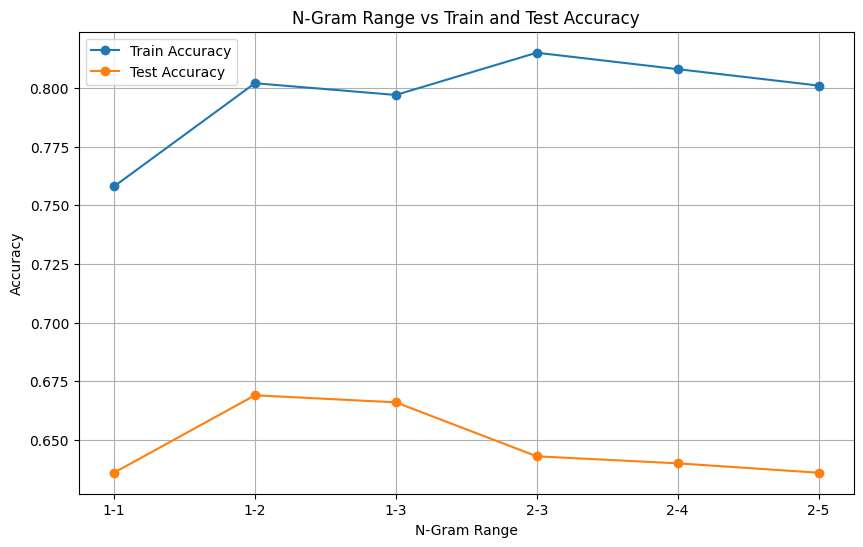

In [87]:
import matplotlib.pyplot as plt

# Data for n-gram ranges and corresponding accuracies
ngram_ranges = ['1-1', '1-2', '1-3', '2-3', '2-4', '2-5']
train_accuracies = [0.758, 0.802, 0.797, 0.815, 0.808, 0.801]
test_accuracies = [0.636, 0.669, 0.666, 0.643, 0.640, 0.636]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(ngram_ranges, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(ngram_ranges, test_accuracies, label='Test Accuracy', marker='o')

# Adding labels, title, and legend
plt.xlabel('N-Gram Range')
plt.ylabel('Accuracy')
plt.title('N-Gram Range vs Train and Test Accuracy')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
